<a href="https://colab.research.google.com/github/Abdul-Waahab/test/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#@title Install libraries
!pip -q install pandas numpy scikit-learn imbalanced-learn xgboost joblib matplotlib seaborn


In [14]:
#@title Imports, config, (optional) output dirs
import os, json, joblib, textwrap, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from pprint import pprint

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
    accuracy_score, precision_score, recall_score, f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Toggle: set True if you ALSO want files on disk (.model etc.)
SAVE_ARTEFACTS = False

if SAVE_ARTEFACTS:
    OUT_BASE = Path("outputs")
    DIR_MODELS  = OUT_BASE / "models"
    for d in (DIR_MODELS,):
        d.mkdir(parents=True, exist_ok=True)
else:
    OUT_BASE = None
    DIR_MODELS = None

plt.rcParams["figure.figsize"] = (7.5, 5.0)
plt.rcParams["axes.grid"] = True

print("Setup OK. SAVE_ARTEFACTS =", SAVE_ARTEFACTS)


Setup OK. SAVE_ARTEFACTS = False


In [15]:
#@title Load the dataset (update path if needed)
DATA_PATH = "Cybersecurity Intrusion Detection.csv"  # <- keep or change to your path

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head(3))
print("\nDtypes:\n", df.dtypes)

# Try to infer target and id-like cols based on your earlier code
candidate_target = "attack_detected" if "attack_detected" in df.columns else None
id_like = [c for c in ["session_id","srcip","dstip","timestamp","flow_id","id"] if c in df.columns]

print("\nGuessed target:", candidate_target)
print("ID-like columns found (will drop):", id_like)


Shape: (9537, 11)


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1



Dtypes:
 session_id              object
network_packet_size      int64
protocol_type           object
login_attempts           int64
session_duration       float64
encryption_used         object
ip_reputation_score    float64
failed_logins            int64
browser_type            object
unusual_time_access      int64
attack_detected          int64
dtype: object

Guessed target: attack_detected
ID-like columns found (will drop): ['session_id']


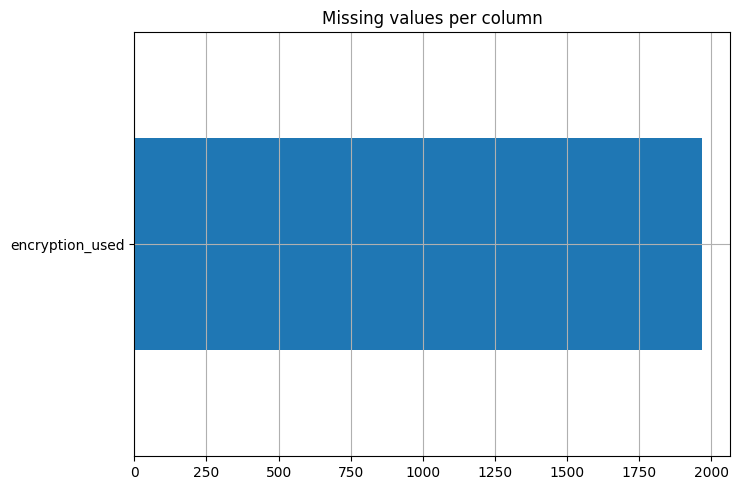

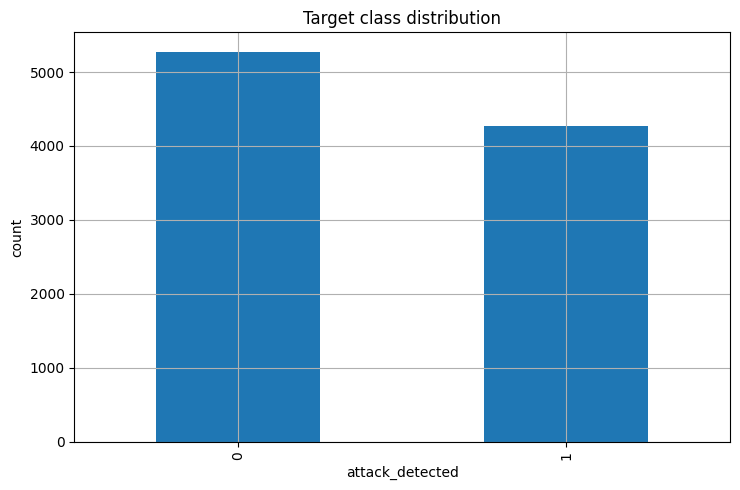

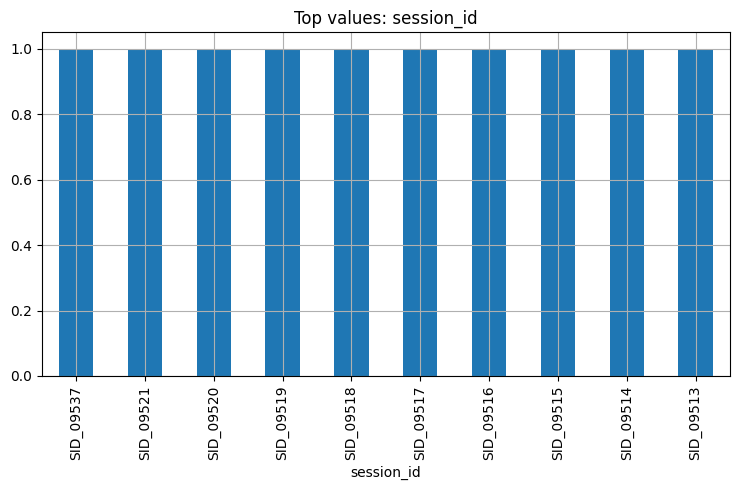

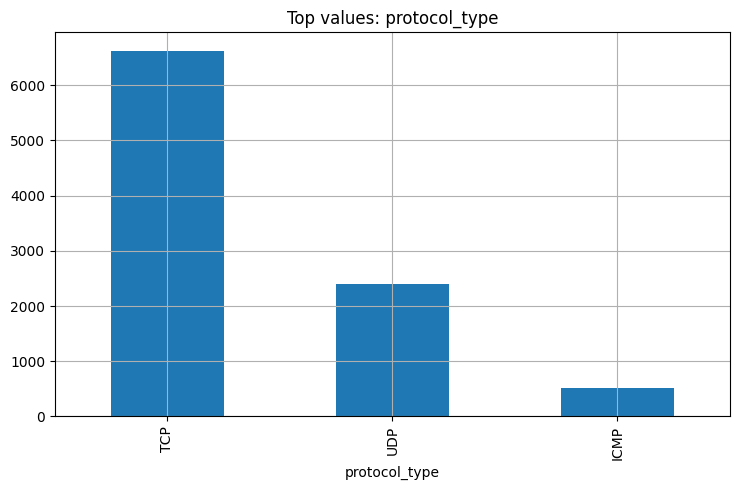

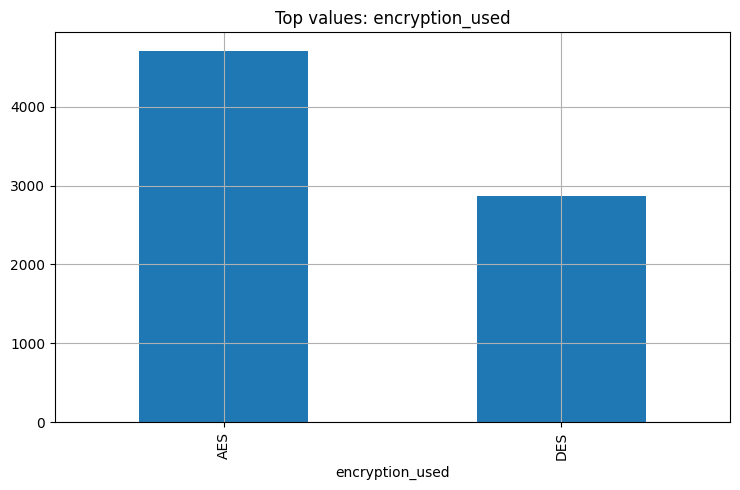

In [16]:
#@title EDA — Missing values, class balance, top categoricals (inline only)

missing = df.isna().sum().sort_values(ascending=False)
if (missing > 0).any():
    ax = missing[missing>0].plot(kind="barh")
    plt.title("Missing values per column")
    plt.tight_layout()
    plt.show()

target = candidate_target
if target is None:
    raise SystemExit("Could not infer target column. Set `candidate_target` to your label name and rerun.")

ax = df[target].value_counts().plot(kind="bar")
plt.title("Target class distribution")
plt.xlabel(target); plt.ylabel("count")
plt.tight_layout(); plt.show()

cat_cols = df.select_dtypes(include=["object","category","bool"]).columns.tolist()
cat_cols = [c for c in cat_cols if c != target]
for c in cat_cols[:3]:
    df[c].value_counts().head(10).plot(kind="bar")
    plt.title(f"Top values: {c}")
    plt.tight_layout(); plt.show()


In [17]:
#@title Clean columns, split, and build leakage-safe preprocessor
# Drop ID-like columns if present
df = df.drop(columns=id_like, errors="ignore")

# Separate X/y
y = df[target]
X = df.drop(columns=[target])

# Identify numeric/categorical
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("Numeric:", len(num_cols), "Categorical:", len(cat_cols))

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

# Preprocessor: imputers + OHE + scaler
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ]
)

# Fit ONLY on train to avoid leakage
preprocessor.fit(X_train)

# Transformed arrays
X_train_proc = preprocessor.transform(X_train)
X_test_proc  = preprocessor.transform(X_test)

print("Train transformed shape:", X_train_proc.shape, "Test transformed shape:", X_test_proc.shape)


Numeric: 6 Categorical: 3
Train transformed shape: (7629, 16) Test transformed shape: (1908, 16)


In [18]:
#@title Helpers: evaluate, plot & show (no files)
def show_confusion_matrix(cm, labels, title):
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks(range(len(labels)), labels, rotation=45)
    plt.yticks(range(len(labels)), labels)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.tight_layout(); plt.show()

def show_roc_curve(y_true, y_proba, title):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_val = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc_val:.3f}")
    plt.plot([0,1],[0,1], "--")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(title); plt.legend(loc="lower right")
    plt.tight_layout(); plt.show()
    return auc_val

def eval_and_show_model(name, clf, Xtr, ytr, Xte, yte, tag="nosmote"):
    # Fit
    clf.fit(Xtr, ytr)

    # Optionally save a deployable pipeline
    if SAVE_ARTEFACTS:
        pipe = Pipeline([("pre", preprocessor), ("clf", clf)])
        model_path = (DIR_MODELS / f"{name}_{tag}.model")
        joblib.dump(pipe, model_path)
        print(f"Saved model: {model_path}")

    # Predict
    y_pred = clf.predict(Xte)
    metrics = {
        "accuracy": accuracy_score(yte, y_pred),
        "precision": precision_score(yte, y_pred, zero_division=0),
        "recall": recall_score(yte, y_pred, zero_division=0),
        "f1": f1_score(yte, y_pred, zero_division=0),
    }

    cm = confusion_matrix(yte, y_pred)
    show_confusion_matrix(cm, labels=[0,1], title=f"Confusion Matrix — {name} ({tag})")

    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(Xte)[:,1]
        metrics["roc_auc"] = show_roc_curve(yte, y_proba, f"ROC — {name} ({tag})")

    print(f"\n{name} ({tag}) — Test Metrics")
    print(metrics)
    print("\nClassification report:")
    print(classification_report(yte, y_pred, digits=4, zero_division=0))

    return metrics



=== LogReg (no SMOTE) ===


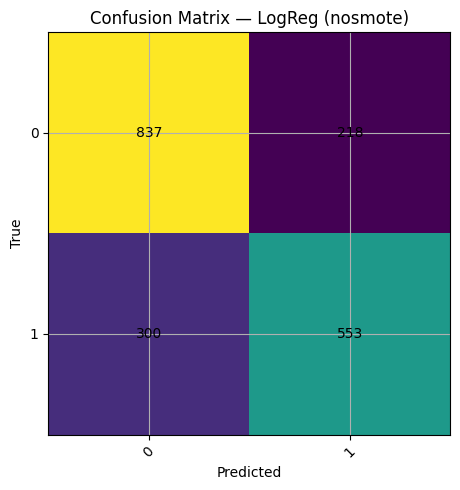

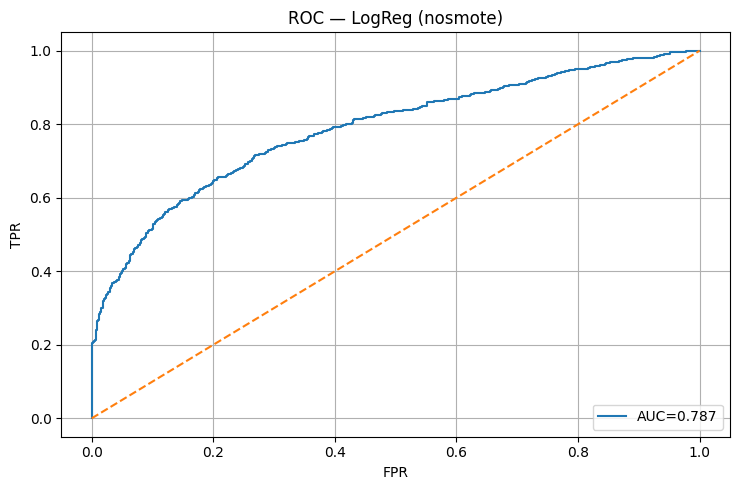


LogReg (nosmote) — Test Metrics
{'accuracy': 0.7285115303983228, 'precision': 0.7172503242542153, 'recall': 0.6483001172332943, 'f1': 0.6810344827586207, 'roc_auc': np.float64(0.7872943555780268)}

Classification report:
              precision    recall  f1-score   support

           0     0.7361    0.7934    0.7637      1055
           1     0.7173    0.6483    0.6810       853

    accuracy                         0.7285      1908
   macro avg     0.7267    0.7208    0.7224      1908
weighted avg     0.7277    0.7285    0.7267      1908


=== RandomForest (no SMOTE) ===


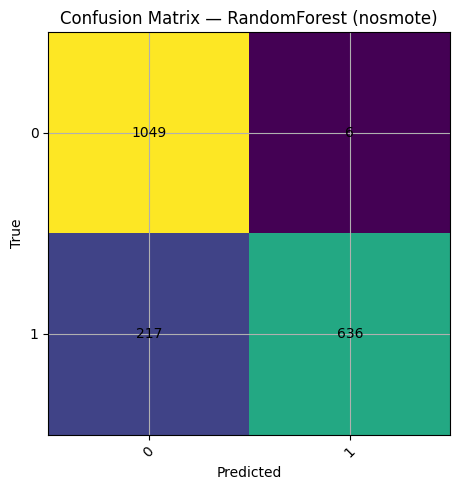

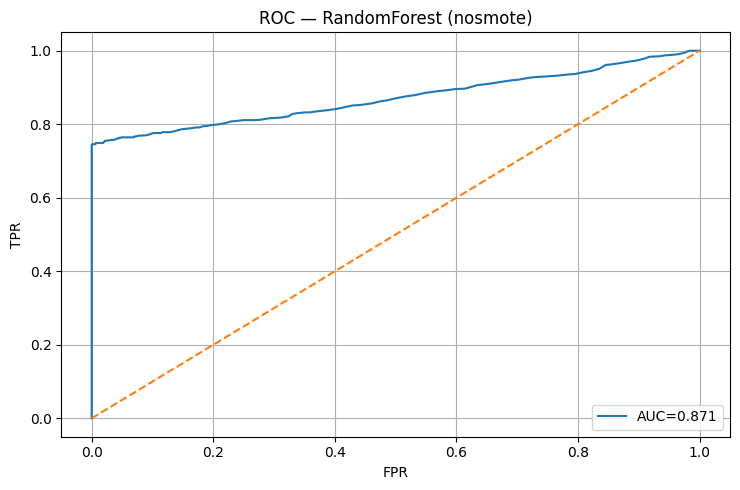


RandomForest (nosmote) — Test Metrics
{'accuracy': 0.8831236897274634, 'precision': 0.9906542056074766, 'recall': 0.7456037514654161, 'f1': 0.8508361204013378, 'roc_auc': np.float64(0.8711322736036182)}

Classification report:
              precision    recall  f1-score   support

           0     0.8286    0.9943    0.9039      1055
           1     0.9907    0.7456    0.8508       853

    accuracy                         0.8831      1908
   macro avg     0.9096    0.8700    0.8774      1908
weighted avg     0.9010    0.8831    0.8802      1908


=== XGBoost (no SMOTE) ===


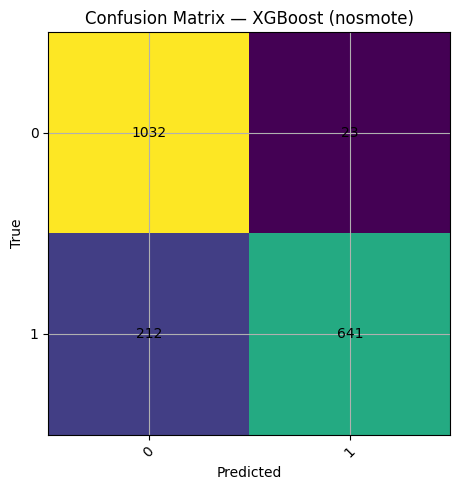

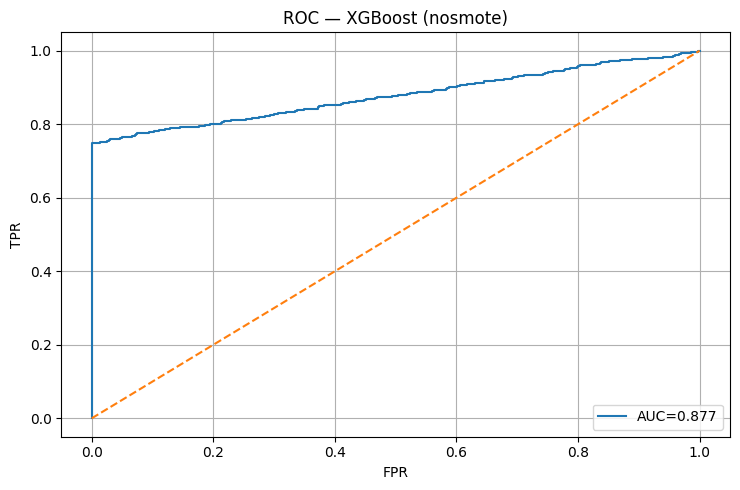


XGBoost (nosmote) — Test Metrics
{'accuracy': 0.8768343815513627, 'precision': 0.9653614457831325, 'recall': 0.7514654161781946, 'f1': 0.8450889914304548, 'roc_auc': np.float64(0.8771817338304173)}

Classification report:
              precision    recall  f1-score   support

           0     0.8296    0.9782    0.8978      1055
           1     0.9654    0.7515    0.8451       853

    accuracy                         0.8768      1908
   macro avg     0.8975    0.8648    0.8714      1908
weighted avg     0.8903    0.8768    0.8742      1908


5-fold CV (F1) on train:


,cv_f1_mean,cv_f1_std
LogReg,0.699548,0.011954
RandomForest,0.866670,0.010859
XGBoost,0.857094,0.010921


In [19]:
#@title Baselines (no SMOTE) + 5-fold CV (inline only)
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1),
    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE, n_estimators=400, learning_rate=0.08, max_depth=7,
        subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0, eval_metric="logloss", n_jobs=-1
    ),
}

baseline_metrics = {}
for name, clf in models.items():
    print(f"\n=== {name} (no SMOTE) ===")
    baseline_metrics[name] = eval_and_show_model(name, clf, X_train_proc, y_train, X_test_proc, y_test, tag="nosmote")

# 5-fold CV on train (F1)
cv_results = {}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for name, clf in models.items():
    pipe_cv = Pipeline([("pre", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe_cv, X_train, y_train, cv=skf, scoring="f1")
    cv_results[name] = {"cv_f1_mean": float(scores.mean()), "cv_f1_std": float(scores.std())}

print("\n5-fold CV (F1) on train:")
display(pd.DataFrame(cv_results).T)



=== LogReg (SMOTE) ===


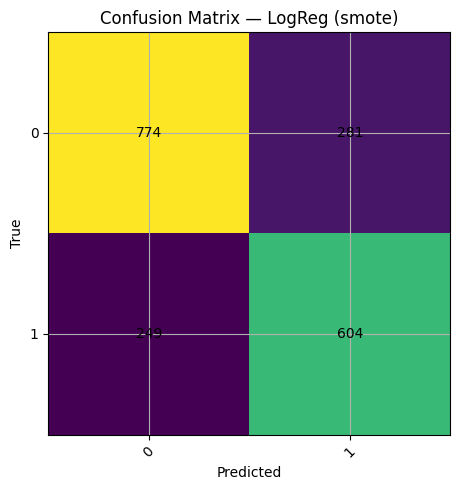

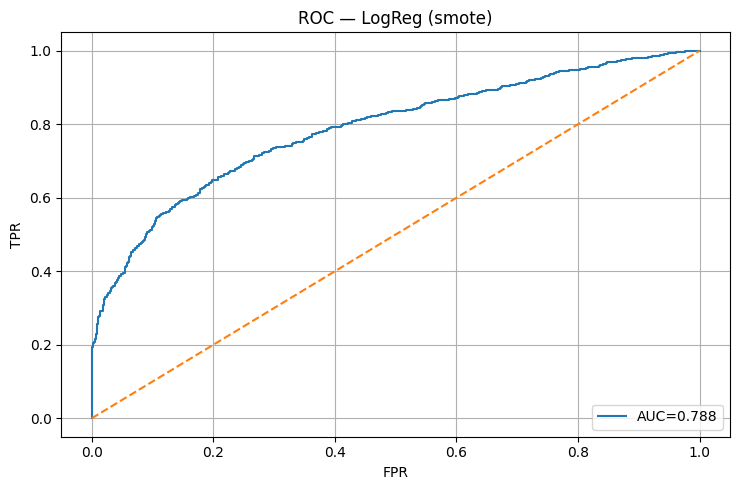


LogReg (smote) — Test Metrics
{'accuracy': 0.7222222222222222, 'precision': 0.6824858757062147, 'recall': 0.7080890973036342, 'f1': 0.6950517836593786, 'roc_auc': np.float64(0.787631054043993)}

Classification report:
              precision    recall  f1-score   support

           0     0.7566    0.7336    0.7449      1055
           1     0.6825    0.7081    0.6951       853

    accuracy                         0.7222      1908
   macro avg     0.7195    0.7209    0.7200      1908
weighted avg     0.7235    0.7222    0.7226      1908


=== RandomForest (SMOTE) ===


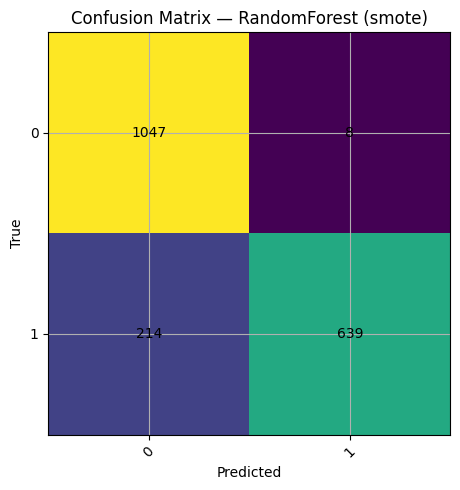

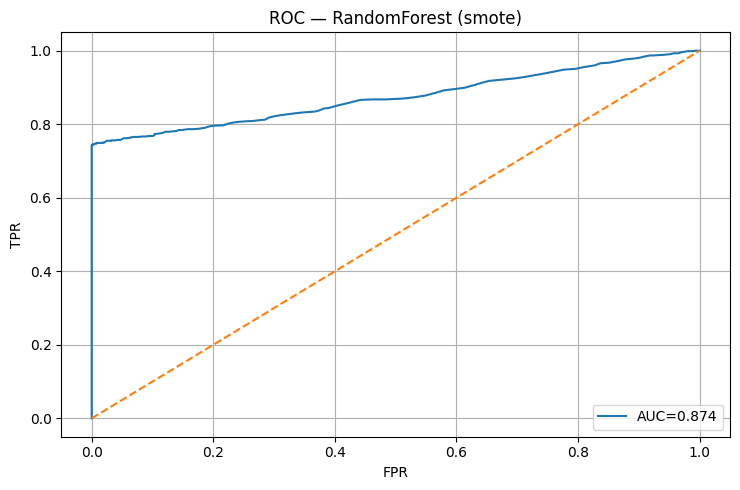


RandomForest (smote) — Test Metrics
{'accuracy': 0.8836477987421384, 'precision': 0.9876352395672334, 'recall': 0.7491207502930832, 'f1': 0.852, 'roc_auc': np.float64(0.873852530516771)}

Classification report:
              precision    recall  f1-score   support

           0     0.8303    0.9924    0.9041      1055
           1     0.9876    0.7491    0.8520       853

    accuracy                         0.8836      1908
   macro avg     0.9090    0.8708    0.8781      1908
weighted avg     0.9006    0.8836    0.8808      1908


=== XGBoost (SMOTE) ===


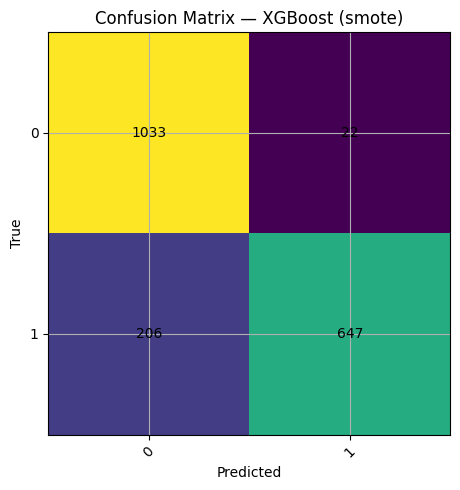

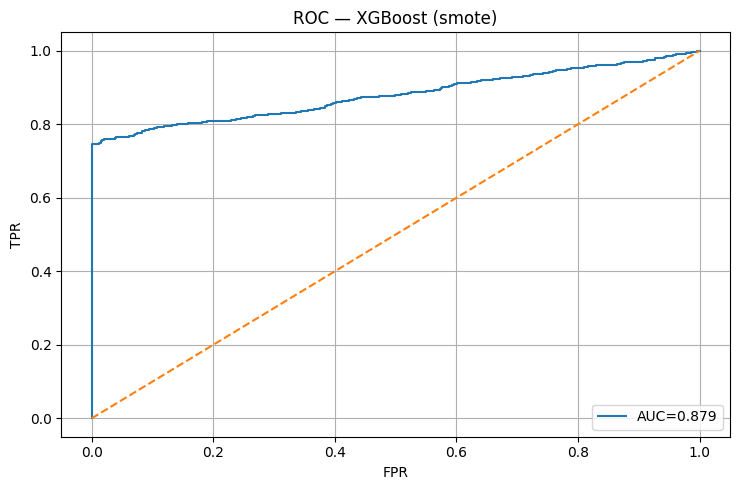


XGBoost (smote) — Test Metrics
{'accuracy': 0.8805031446540881, 'precision': 0.9671150971599403, 'recall': 0.7584994138335287, 'f1': 0.8501971090670171, 'roc_auc': np.float64(0.8789496785807549)}

Classification report:
              precision    recall  f1-score   support

           0     0.8337    0.9791    0.9006      1055
           1     0.9671    0.7585    0.8502       853

    accuracy                         0.8805      1908
   macro avg     0.9004    0.8688    0.8754      1908
weighted avg     0.8934    0.8805    0.8781      1908



In [20]:
#@title SMOTE ablation (oversample train only, inline only)
sm = SMOTE(random_state=RANDOM_STATE)
X_train_sm, y_train_sm = sm.fit_resample(X_train_proc, y_train)

smote_metrics = {}
for name, clf in models.items():
    print(f"\n=== {name} (SMOTE) ===")
    smote_metrics[name] = eval_and_show_model(name, clf, X_train_sm, y_train_sm, X_test_proc, y_test, tag="smote")


Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params for RandomForest:
{'clf__max_depth': 12, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best CV F1: 0.8681991329948717
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best params for XGBoost:
{'clf__colsample_bytree': 0.8,
 'clf__learning_rate': 0.05,
 'clf__max_depth': 5,
 'clf__n_estimators': 300,
 'clf__subsample': 0.8}
Best CV F1: 0.868180360459006


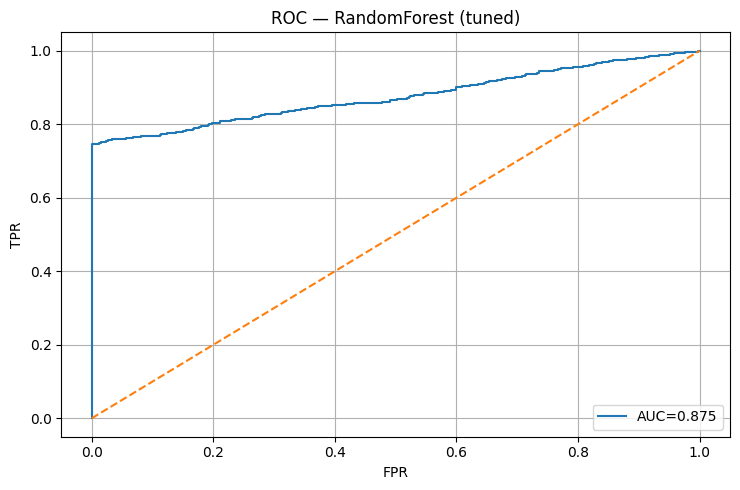

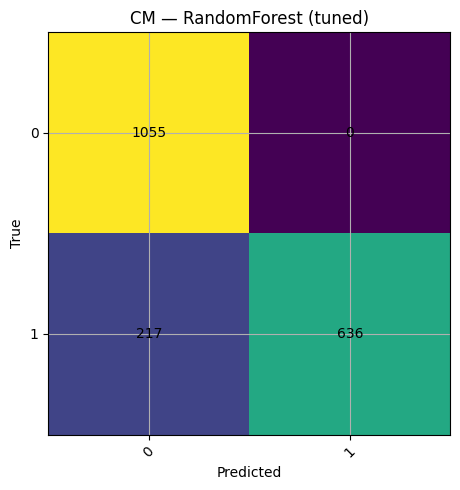


RandomForest (tuned) — Test Metrics
{'accuracy': 0.8862683438155137,
 'f1': 0.8542646071188718,
 'precision': 1.0,
 'recall': 0.7456037514654161,
 'roc_auc': np.float64(0.8754437919136808)}

Classification report:
              precision    recall  f1-score   support

           0     0.8294    1.0000    0.9067      1055
           1     1.0000    0.7456    0.8543       853

    accuracy                         0.8863      1908
   macro avg     0.9147    0.8728    0.8805      1908
weighted avg     0.9057    0.8863    0.8833      1908



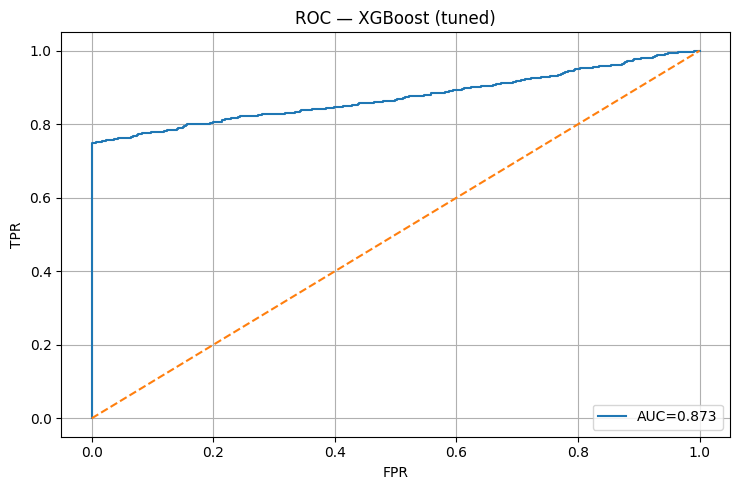

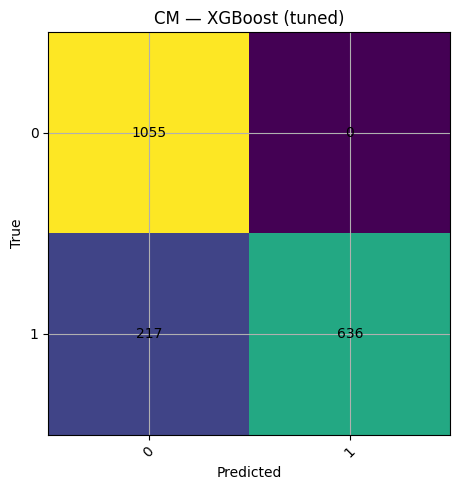


XGBoost (tuned) — Test Metrics
{'accuracy': 0.8862683438155137,
 'f1': 0.8542646071188718,
 'precision': 1.0,
 'recall': 0.7456037514654161,
 'roc_auc': np.float64(0.8733791524755116)}

Classification report:
              precision    recall  f1-score   support

           0     0.8294    1.0000    0.9067      1055
           1     1.0000    0.7456    0.8543       853

    accuracy                         0.8863      1908
   macro avg     0.9147    0.8728    0.8805      1908
weighted avg     0.9057    0.8863    0.8833      1908



In [21]:
#@title Hyperparameter tuning (compact grids) + test eval (inline only)
grids = {
    "RandomForest": {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [None, 12, 20],
        "clf__min_samples_split": [2, 5]
    },
    "XGBoost": {
        "clf__n_estimators": [300, 500],
        "clf__max_depth": [5, 7],
        "clf__learning_rate": [0.05, 0.1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    }
}

best_models = {}
for name in ["RandomForest","XGBoost"]:
    base_clf = models[name]
    pipe = Pipeline([("pre", preprocessor), ("clf", base_clf)])
    gs = GridSearchCV(pipe, grids[name],
                      cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
                      scoring="f1", n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    print(f"\nBest params for {name}:")
    pprint(gs.best_params_)
    print("Best CV F1:", gs.best_score_)
    best_models[name] = gs.best_estimator_

# Evaluate tuned models on test (inline)
tuned_metrics = {}
for name, best_pipe in best_models.items():
    y_pred = best_pipe.predict(X_test)
    y_proba = best_pipe.predict_proba(X_test)[:,1] if hasattr(best_pipe, "predict_proba") else None

    tm = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "f1": f1_score(y_test, y_pred, zero_division=0)
    }
    if y_proba is not None:
        tm["roc_auc"] = show_roc_curve(y_test, y_proba, f"ROC — {name} (tuned)")

    cm = confusion_matrix(y_test, y_pred)
    show_confusion_matrix(cm, [0,1], f"CM — {name} (tuned)")

    print(f"\n{name} (tuned) — Test Metrics")
    pprint(tm)
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))

    tuned_metrics[name] = tm


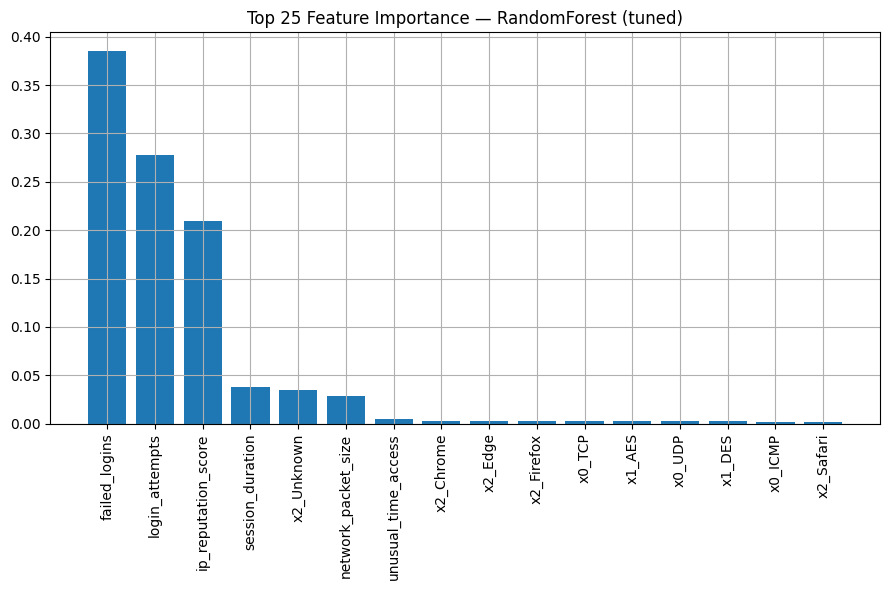

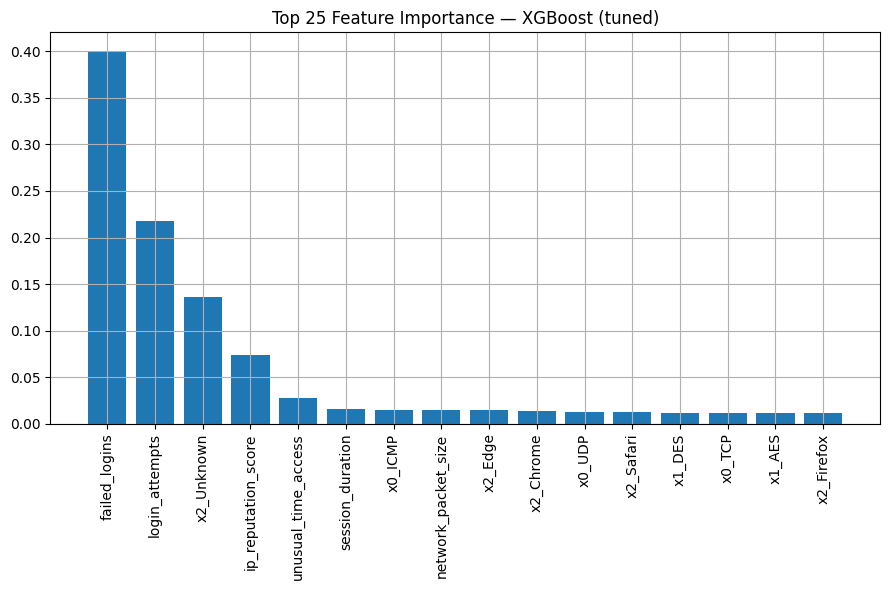

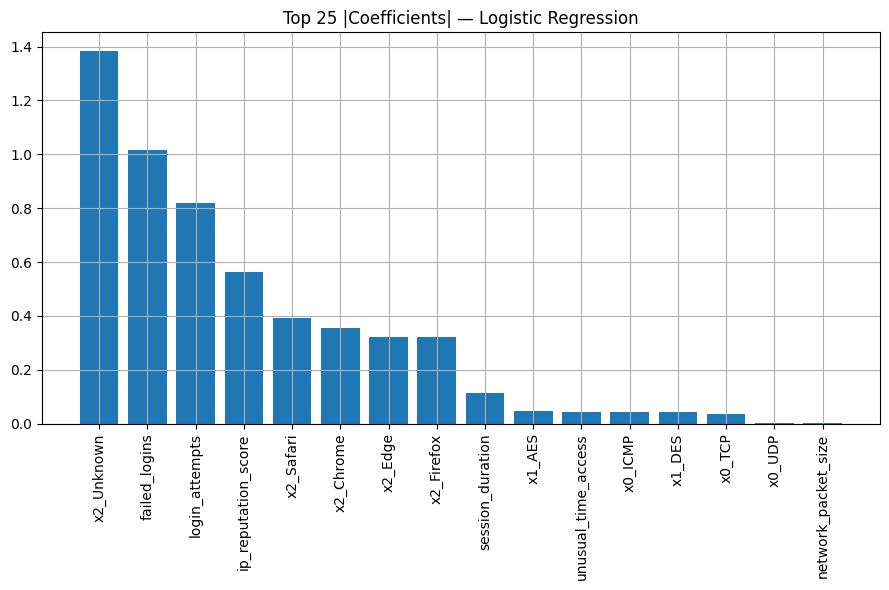

In [22]:
#@title Feature importance / coefficients (inline only)
def feature_names_from_preprocessor(pre):
    # numeric names (imputer may not expose names; fallback)
    try:
        num_names = pre.named_transformers_["num"].named_steps["imputer"].get_feature_names_out()
        num_names = [n.split("__")[-1] for n in num_names]
    except Exception:
        num_names = pre.transformers_[0][2]
    cat_names = pre.named_transformers_["cat"].named_steps["ohe"].get_feature_names_out()
    return list(num_names) + list(cat_names)

# Tuned RF/XGB
for name in ["RandomForest","XGBoost"]:
    if name not in best_models:
        continue
    pipe = best_models[name]
    pre = pipe.named_steps["pre"]; clf = pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        fn = feature_names_from_preprocessor(pre)
        imp = clf.feature_importances_
        order = np.argsort(imp)[::-1][:25]
        plt.figure(figsize=(9,6))
        plt.bar(range(len(order)), imp[order])
        plt.xticks(range(len(order)), [fn[i] for i in order], rotation=90)
        plt.title(f"Top 25 Feature Importance — {name} (tuned)")
        plt.tight_layout(); plt.show()

# LR absolute coefficients
lr_pipe = Pipeline([("pre", preprocessor), ("clf", LogisticRegression(max_iter=1000))])
lr_pipe.fit(X_train, y_train)
lr = lr_pipe.named_steps["clf"]
if hasattr(lr, "coef_"):
    pre = lr_pipe.named_steps["pre"]
    fn = feature_names_from_preprocessor(pre)
    coefs = np.abs(lr.coef_.ravel())
    order = np.argsort(coefs)[::-1][:25]
    plt.figure(figsize=(9,6))
    plt.bar(range(len(order)), coefs[order])
    plt.xticks(range(len(order)), [fn[i] for i in order], rotation=90)
    plt.title("Top 25 |Coefficients| — Logistic Regression")
    plt.tight_layout(); plt.show()


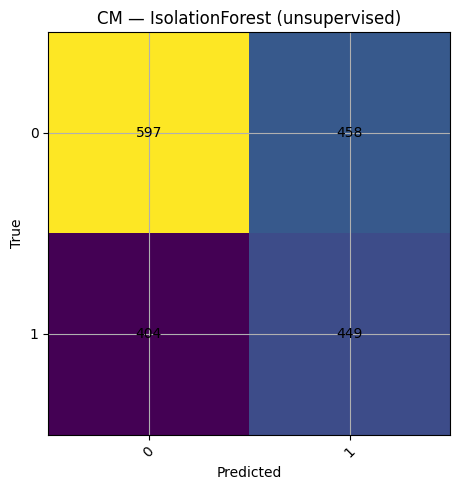

Isolation Forest metrics:
{'accuracy': 0.5482180293501048,
 'f1': 0.5102272727272728,
 'precision': 0.49503858875413453,
 'recall': 0.5263774912075029}


In [23]:
#@title Optional: Isolation Forest (unsupervised) — inline
iso = IsolationForest(n_estimators=300, contamination="auto", random_state=RANDOM_STATE, n_jobs=-1)
mask_normal = (y_train == 0)
iso.fit(X_train_proc[mask_normal])

pred_test = iso.predict(X_test_proc)   # -1 anomaly, 1 normal
y_pred_iso = np.where(pred_test == -1, 1, 0)

iso_metrics = {
    "accuracy": accuracy_score(y_test, y_pred_iso),
    "precision": precision_score(y_test, y_pred_iso, zero_division=0),
    "recall": recall_score(y_test, y_pred_iso, zero_division=0),
    "f1": f1_score(y_test, y_pred_iso, zero_division=0)
}
cm = confusion_matrix(y_test, y_pred_iso)
show_confusion_matrix(cm, [0,1], "CM — IsolationForest (unsupervised)")
print("Isolation Forest metrics:"); pprint(iso_metrics)


In [24]:
#@title Consolidate metrics across runs (inline only)
def to_rows(block, run):
    if not block: return []
    return [{"run": run, "model": k, **v} for k, v in block.items()]

rows = []
rows += to_rows(baseline_metrics, "baseline_nosmote")
rows += to_rows(smote_metrics, "smote")
rows += to_rows(tuned_metrics, "tuned")

# Add ISO if present
try:
    rows.append({"run":"unsupervised", "model":"IsolationForest", **iso_metrics})
except Exception:
    pass

lb = pd.DataFrame(rows)
if lb.empty:
    print("No metrics collected. Run baseline/smote/tuning cells first.")
else:
    sort_keys = [k for k in ["f1","roc_auc","accuracy"] if k in lb.columns]
    lb = lb.sort_values(by=sort_keys, ascending=False)
    display(lb)


,run,model,accuracy,precision,recall,f1,roc_auc
6,tuned,RandomForest,0.886268,1.000000,0.745604,0.854265,0.875444
7,tuned,XGBoost,0.886268,1.000000,0.745604,0.854265,0.873379
4,smote,RandomForest,0.883648,0.987635,0.749121,0.852000,0.873853
1,baseline_nosmote,RandomForest,0.883124,0.990654,0.745604,0.850836,0.871132
5,smote,XGBoost,0.880503,0.967115,0.758499,0.850197,0.878950
2,baseline_nosmote,XGBoost,0.876834,0.965361,0.751465,0.845089,0.877182
3,smote,LogReg,0.722222,0.682486,0.708089,0.695052,0.787631
0,baseline_nosmote,LogReg,0.728512,0.717250,0.648300,0.681034,0.787294
8,unsupervised,IsolationForest,0.548218,0.495039,0.526377,0.510227,NaN
